# COMP 352 Final Project

**Authors:** Lucca Fabani and Daniel Daugbjerg

**Date:** 5/1/24

#### Dataset: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset 

# Data Importing and Preprocessing

In [59]:

# import libraries needed
import pandas as pd

pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, skew, probplot
import warnings
import seaborn as sns
from scipy.special import boxcox1p

In [60]:
#read in the data file
track_df = pd.read_csv("dataset.csv")

In [61]:
#rows and columns of table
track_df.shape

(114000, 21)

In [62]:
#number of categorical variables
cat_num = 0
for dtype in track_df.dtypes:
    if dtype == "object":
        cat_num = cat_num + 1

In [63]:
print("# of categorical variables:", cat_num)

#rest of the columns are numeric
numeric_vars = track_df.shape[1] - cat_num - 2 #subtract 2 columns for number and track id columns
print("# of numeric variables:", numeric_vars) 

# of categorical variables: 5
# of numeric variables: 14


In [64]:
track_df.head()

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1         0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2         0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3         0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4         0.618  0.4430    2    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature track_genre  
0          0.000001    0.3580    0.715   87.917               4    acoustic  
1          0.000006    0.1010    0.267   77.489               4    acoustic  
2          0.000000    0.1170    0.120   76.332               4    acoustic  
3          0.000071    0.1320    0.143  181.740               3    acoustic  
4          0.000000    0.0829    0.167  119.949               4    acoustic

Handle Missing Data

In [65]:
#remove the unnamed 'order' column
track_df = track_df.drop(columns=["Unnamed: 0","album_name","track_name","artists"])
# missing data
total = track_df.isnull().sum().sort_values(ascending=False)
percent = (track_df.isnull().sum() / track_df.isnull().count()).sort_values(
    ascending=False
)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

Total  Percent
track_id              0      0.0
speechiness           0      0.0
time_signature        0      0.0
tempo                 0      0.0
valence               0      0.0
liveness              0      0.0
instrumentalness      0      0.0
acousticness          0      0.0
mode                  0      0.0
popularity            0      0.0
loudness              0      0.0
key                   0      0.0
energy                0      0.0
danceability          0      0.0
explicit              0      0.0
duration_ms           0      0.0
track_genre           0      0.0

Since we do not need to worry about missing album names, track names, or artist names, nothing needs to be changed here. 

In [66]:
# We are checking to see if any columns are largely homogeneous
# Homogeneous columns provide no value to our model and can sometimes lead to overfitting
print("Categorical Columns Mode Frequency")

cat_columns = track_df.select_dtypes(include=["object"]).columns

mode_freq_df = pd.DataFrame(columns=["column_name", "mode_frequency"])

for col in cat_columns:
    mode_value = track_df[col].mode().values[0]
    mode_freq = (track_df[col] == mode_value).mean()
    row_data = pd.DataFrame([{"column_name": col, "mode_frequency": mode_freq}])
    mode_freq_df = pd.concat([mode_freq_df,row_data], ignore_index= True)
mode_freq_df.sort_values("mode_frequency", ascending=False).head(10)

Categorical Columns Mode Frequency


/var/folders/d8/r30nz4q57b17kphtz7nm89b40000gn/T/ipykernel_73335/2119238300.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mode_freq_df = pd.concat([mode_freq_df,row_data], ignore_index= True)


column_name  mode_frequency
1  track_genre        0.008772
0     track_id        0.000079

Almost no Homogeneity within this dataset, so there is nothing to filter out!

In [67]:
# Check remaining missing values if any
all_data_na = track_df.isnull().sum() / len(track_df)
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(
    ascending=False
)
missing_data = pd.DataFrame({"Missing Ratio": all_data_na})
missing_data.head()

Empty DataFrame
Columns: [Missing Ratio]
Index: []

Handling non 0-1 range values:
certain columns (i.e tempo, loudness) have values that are not within a [0,1] range. We will use minmax scaling to bring it to a [0,1] range

In [68]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Reshape the 'tempo' and 'loudness' column to a 2D array as required by MinMaxScaler
tempo_values = track_df['tempo'].values.reshape(-1, 1)

loudness_values = track_df['loudness'].values.reshape(-1,1)
# Fit the scaler to the tempo and loudness values and transform them
scaled_tempo = scaler.fit_transform(tempo_values)
scaled_loudness = scaler.fit_transform(loudness_values)


# Replace the original 'tempo' and 'loudness' column with the scaled values
track_df['tempo'] = scaled_tempo
track_df['loudness'] = scaled_loudness
# Now the 'tempo' and 'loudness' column values are scaled between 0 and 1

Handling Outliers

Make 'general' genres using NLP models and K-mean

In [69]:
!pip3 install spacy

# Data Analysis and Visualization

In [70]:

import numpy as np
import spacy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load spaCy's pre-trained word vectors model
nlp = spacy.load("en_core_web_md")

# Step 1: Collect genre names
genre_names = track_df['track_genre'].unique()

print(genre_names)

genre_mappings = {
    'Acoustic': ['acoustic'],
    'World Music': ['afrobeat', 'brazil', 'cantopop', 'french', 'forro', 'german', 'indian', 'iranian', 'j-dance', 'j-idol', 'j-pop', 'j-rock', 'k-pop', 'malay', 'mandopop', 'mpb', 'new-age', 'pagode', 'samba', 'sertanejo', 'spanish', 'swedish', 'tango', 'turkish', 'world-music'],
    'Rock': ['alt-rock', 'alternative', 'british', 'emo', 'goth', 'grunge', 'guitar', 'hard-rock', 'hardcore', 'indie', 'industrial', 'psych-rock', 'punk-rock', 'punk', 'rock-n-roll', 'rock', 'rockabilly'],
    'Blues': ['blues'],
    'Country': ['bluegrass', 'country', 'honky-tonk'],
    'Electronic': ['ambient', 'breakbeat', 'chicago-house', 'club', 'deep-house', 'detroit-techno', 'disco', 'dub', 'dubstep', 'edm', 'electro', 'electronic', 'garage', 'house', 'idm', 'progressive-house', 'techno', 'trance', 'trip-hop'],
    'Children': ['children', 'disney', 'kids'],
    'Classical': ['classical', 'opera', 'piano'],
    'Comedy': ['comedy'],
    'Reggae': ['dancehall', 'reggae', 'ska'],
    'Metal': ['black-metal', 'death-metal', 'grindcore', 'heavy-metal', 'metal', 'metalcore'],
    'Folk': ['folk', 'singer-songwriter', 'songwriter'],
    'Pop': ['anime', 'chill', 'dance', 'happy', 'pop-film', 'pop', 'power-pop', 'romance', 'sad', 'show-tunes'],
    'Funk': ['funk'],
    'Gospel': ['gospel'],
    'Jazz': ['jazz'],
    'R&B': ['r-n-b', 'soul'],
    'Latin': ['brazil', 'latin', 'latino', 'salsa'],
    'Hip-hop': ['hip-hop'],
    'Punk': ['punk', 'punk-rock'],
    'Techno': ['minimal-techno'],
    'Party': ['party'],
    'Sleep': ['sleep'],
    'Study': ['study']
}




['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
 'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
 'reggaeton' 'rock-n-roll' 'rock' 'rockabilly' 'romance' 'sad' 'salsa'
 'samba' 'sertanejo' 'show

Get numerical cols first

In [71]:
numerical_columns = []

for col, dtype in track_df.dtypes.items():
    if dtype == "float64":
        numerical_columns.append(col)

print("Numerical Columns:", numerical_columns)

Numerical Columns: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


Now plot those to see which may have outlier vals

/var/folders/d8/r30nz4q57b17kphtz7nm89b40000gn/T/ipykernel_73335/3698425724.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


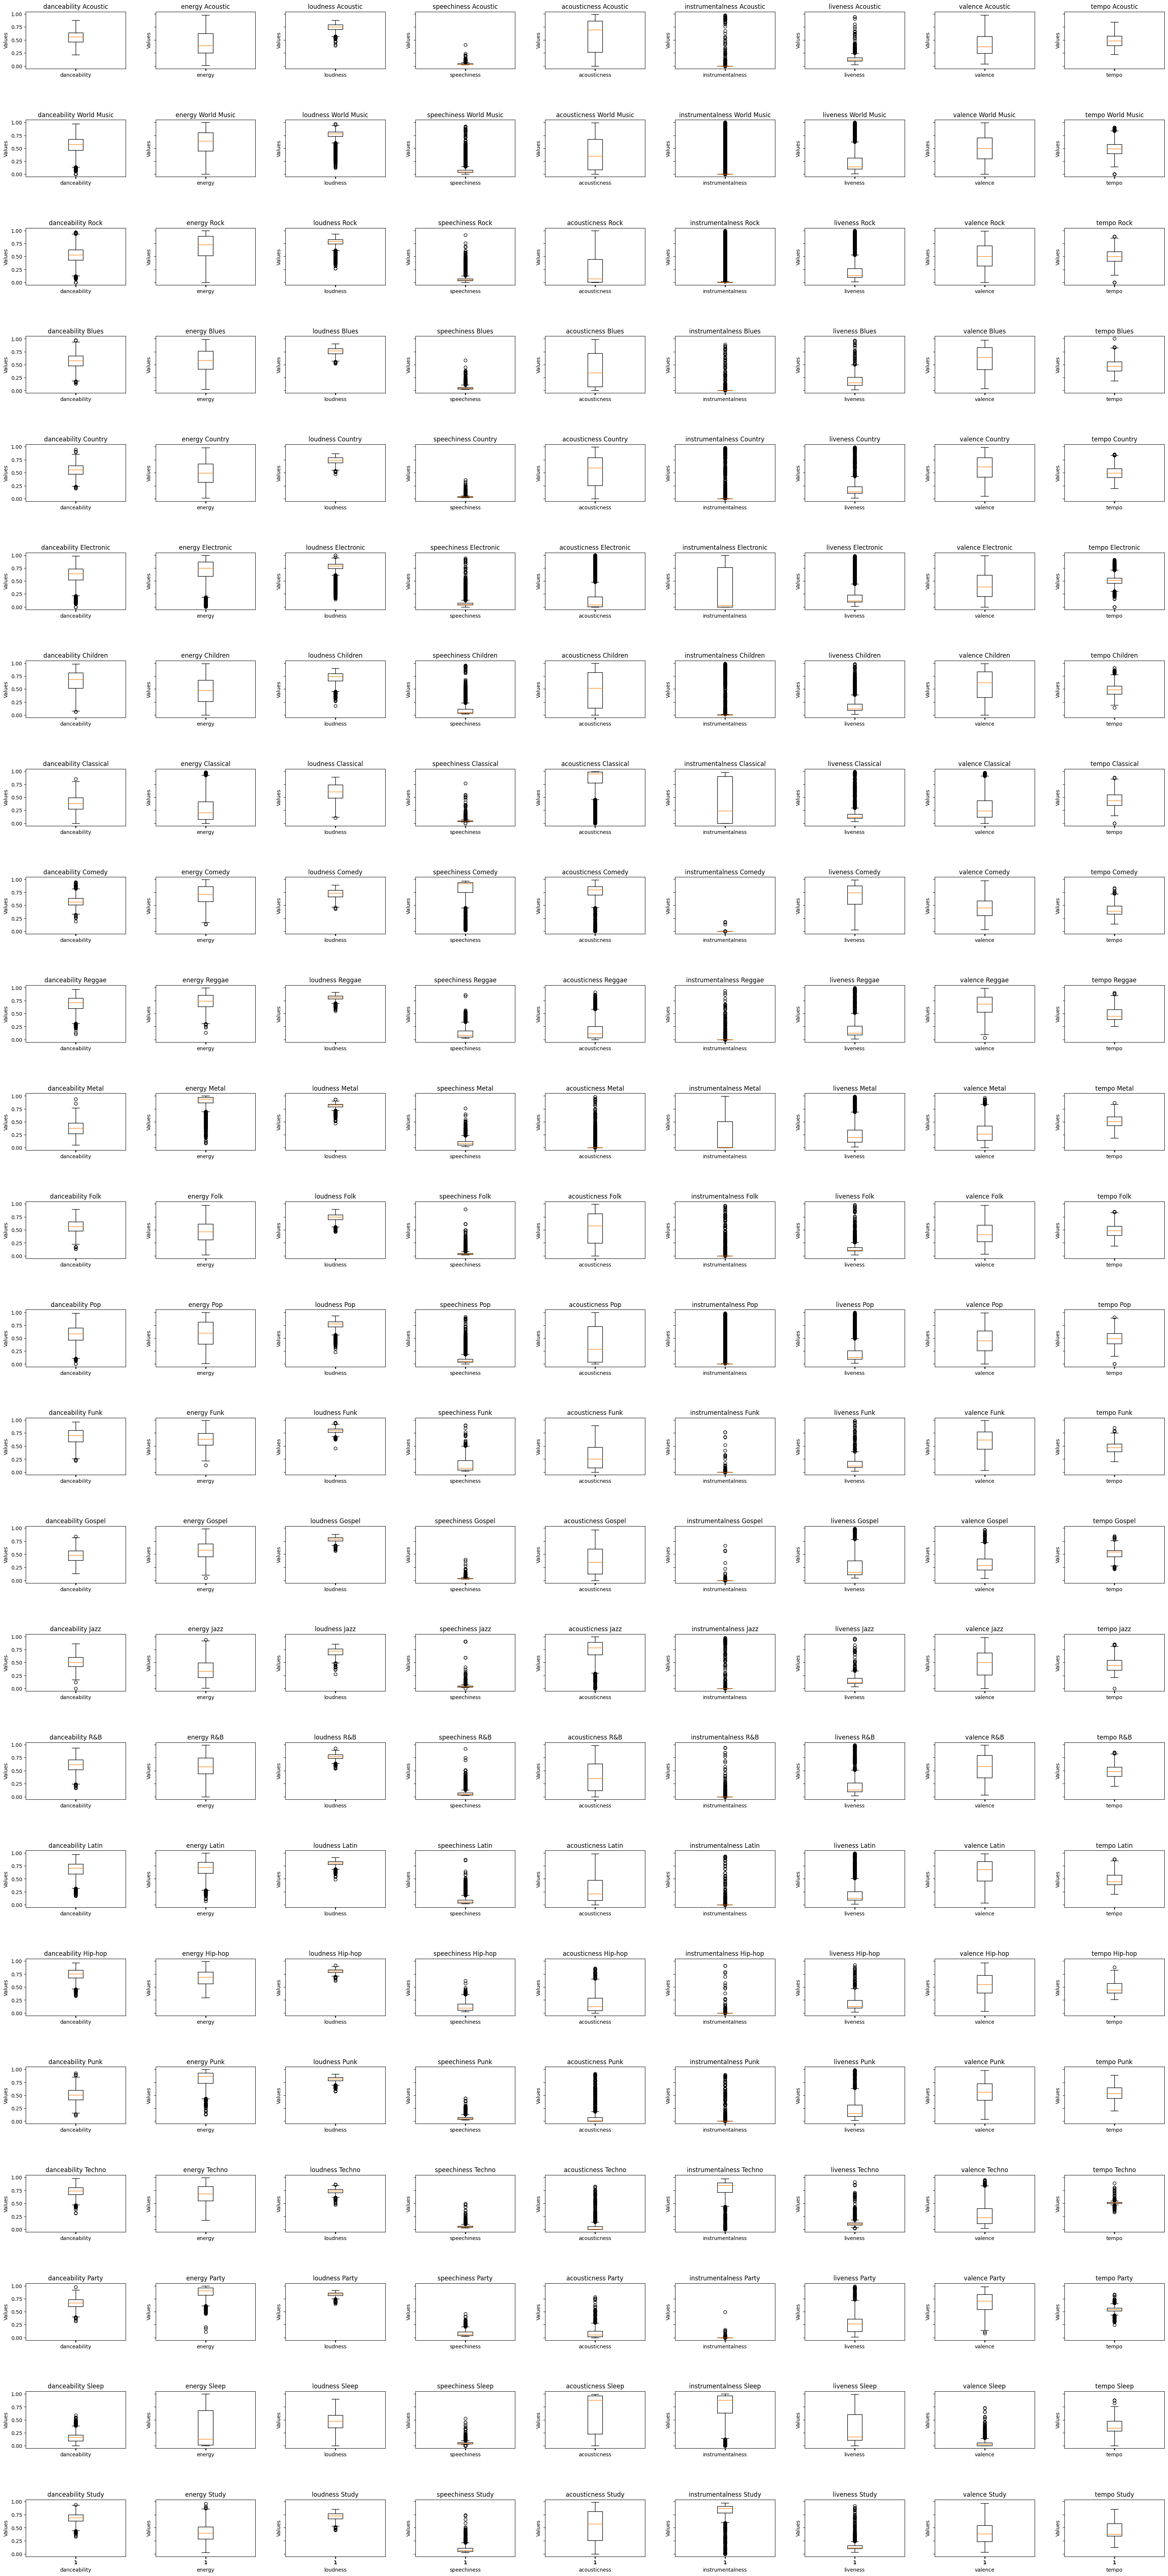

In [72]:

import matplotlib.pyplot as plt

# Define the number of rows and columns for subplots
num_rows = len(genre_mappings)
num_cols = len(numerical_columns)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 90), sharex='col', sharey='row', 
                         gridspec_kw={'hspace': 0.9, 'wspace': 0.3})

# Iterate over each basic genre
for i, (basic_genre, subgenres) in enumerate(genre_mappings.items()):
    # Filter the DataFrame for tracks belonging to the current basic genre
    filtered_df = track_df[track_df['track_genre'].isin(subgenres)]
    
    # Iterate over each numerical column
    for j, col in enumerate(numerical_columns):
        # Box plot
        axes[i, j].boxplot(filtered_df[col])
        axes[i, j].set_title(f"{col} {basic_genre}")
        axes[i, j].set_xlabel(col)
        axes[i, j].set_ylabel("Values")

# Adjust layout
plt.tight_layout()
plt.show()


Lets graph the most irregular columns to their genre to see if there are many outliers, this can lead to overfitting. 

/var/folders/d8/r30nz4q57b17kphtz7nm89b40000gn/T/ipykernel_73335/3492153562.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


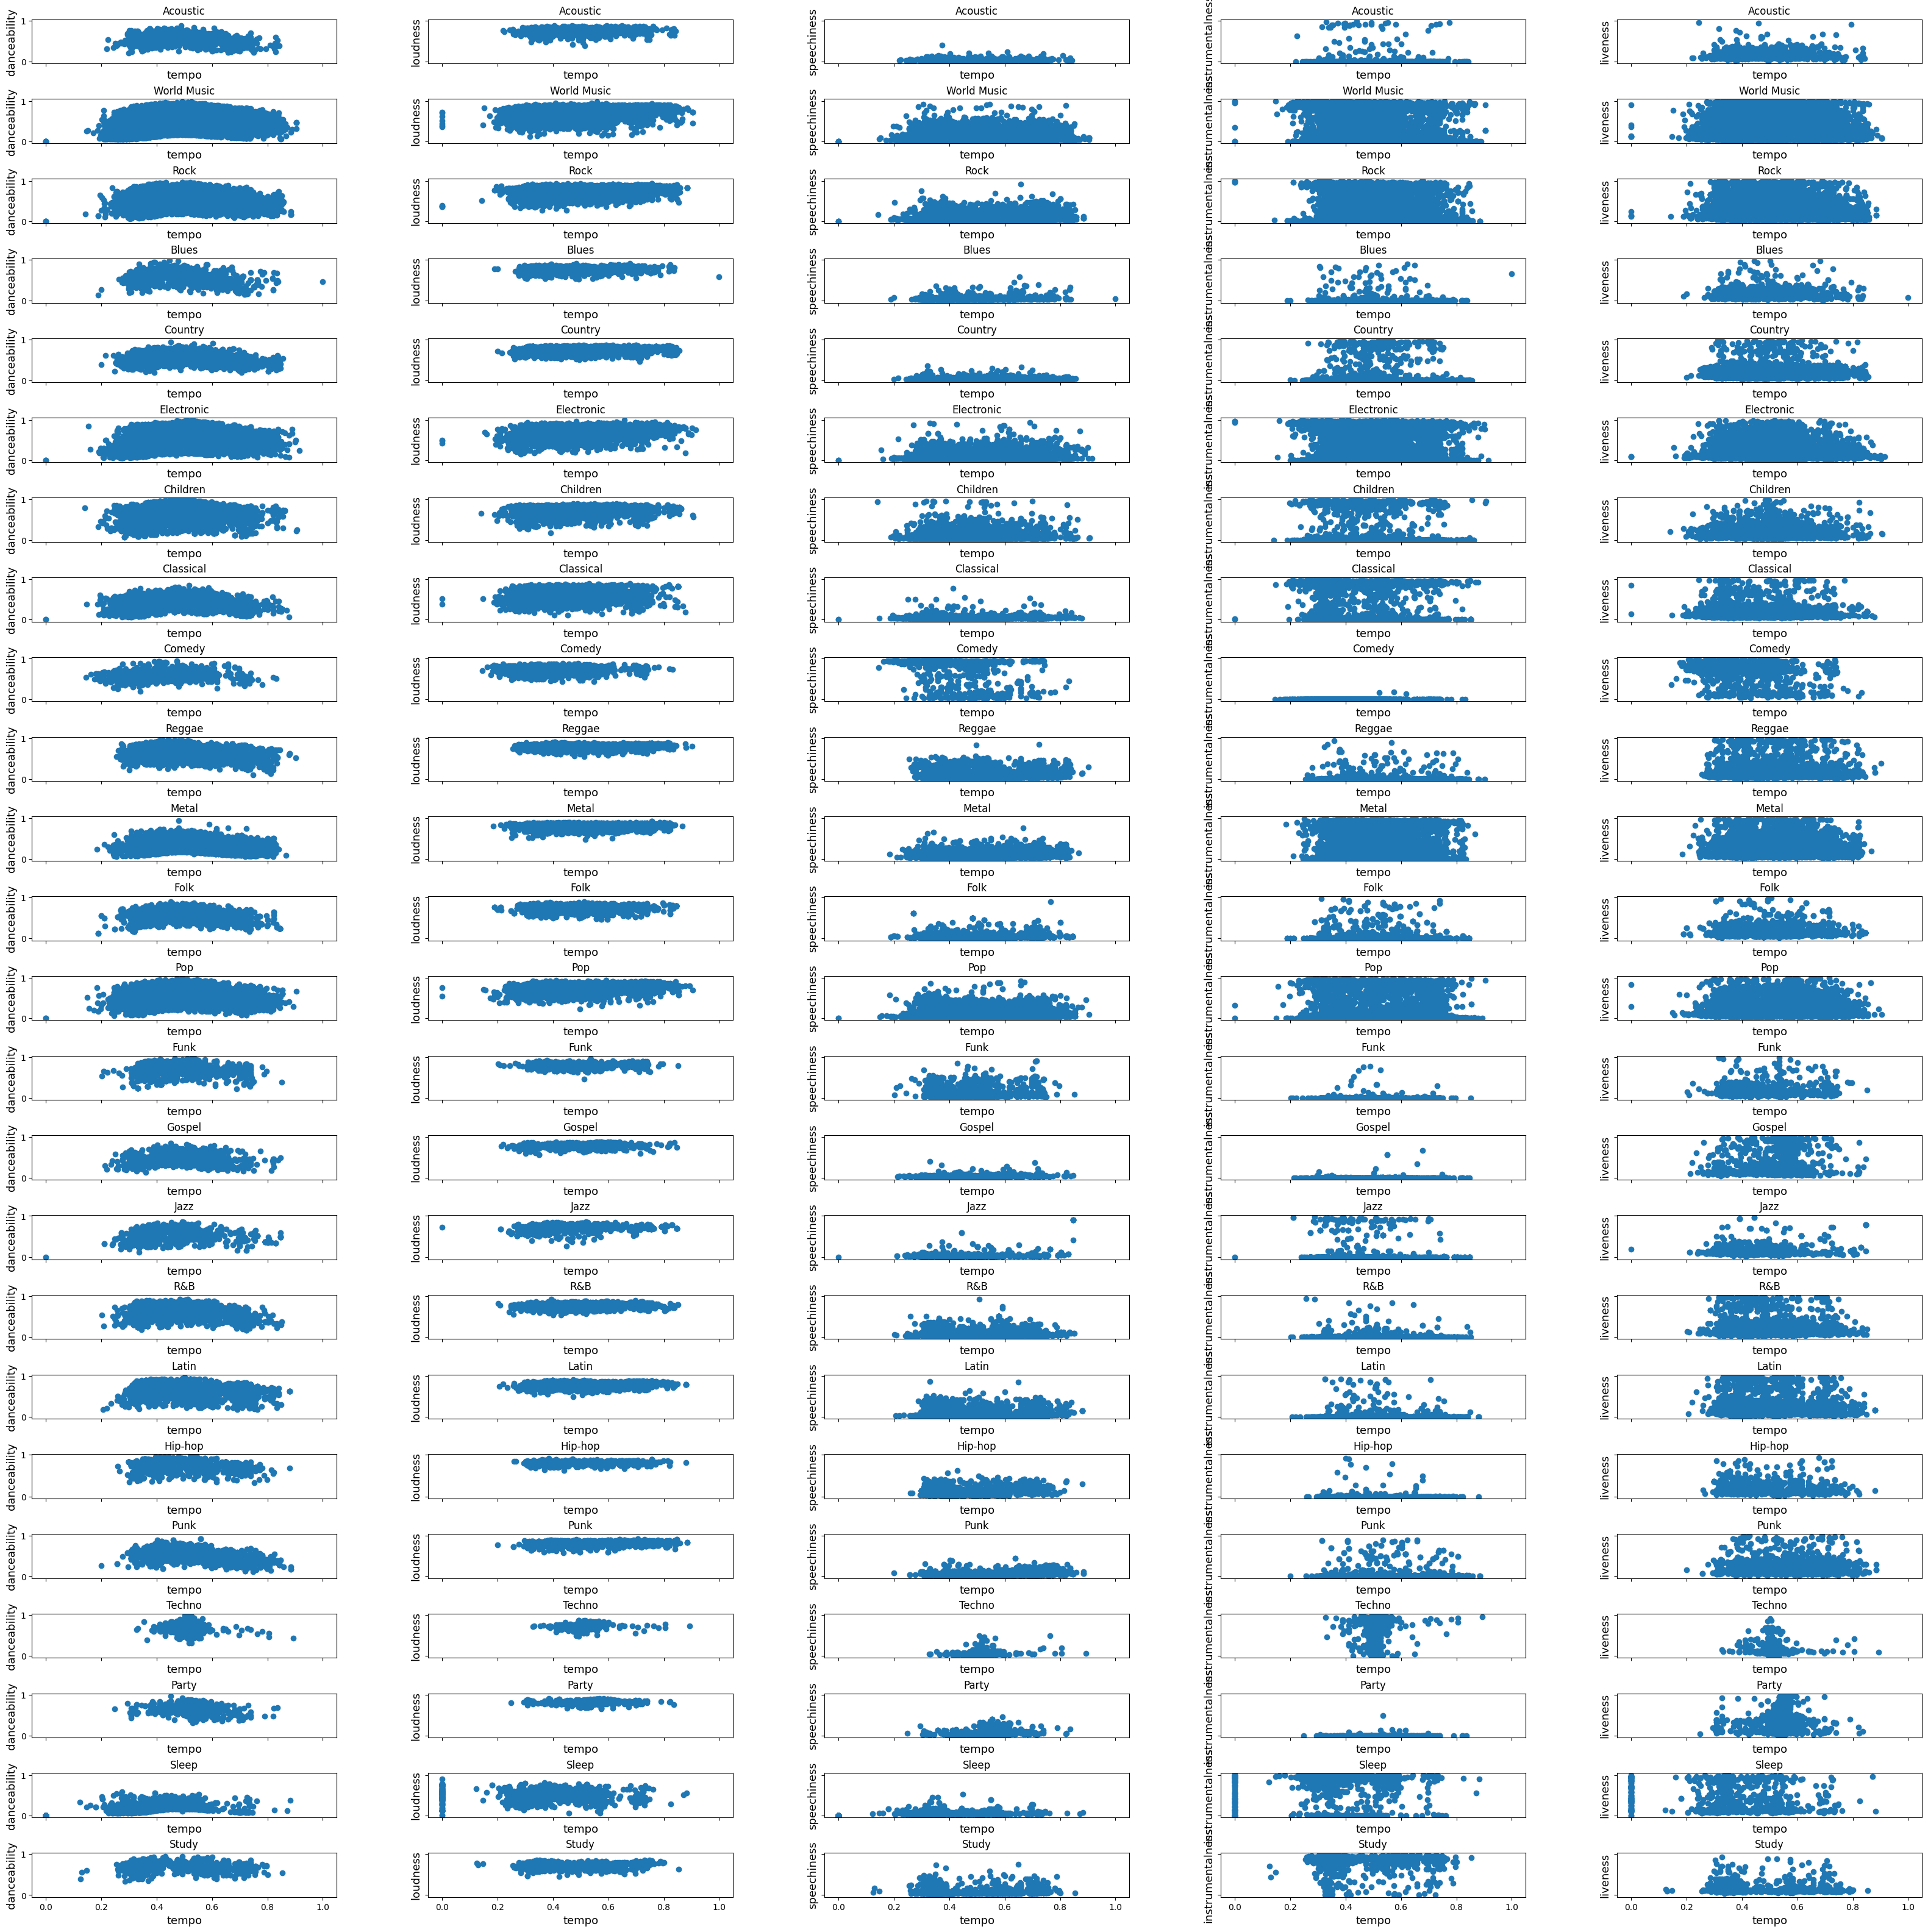

In [73]:
potential_outliers = ["danceability", "loudness", "speechiness", "instrumentalness", "liveness"]


# Define the number of rows and columns for subplots
num_rows = len(genre_mappings)
num_cols = len(potential_outliers)

# Create subplots with spacing
fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 40), sharex='col', sharey='row', 
                         gridspec_kw={'hspace': 0.8, 'wspace': 0.3})

# Iterate over each basic genre
for i, (basic_genre, subgenres) in enumerate(genre_mappings.items()):
    # Filter the DataFrame for tracks belonging to the current basic genre
    filtered_df = track_df[track_df['track_genre'].isin(subgenres)]
    
    # Iterate over each potential outlier column
    for j, col in enumerate(potential_outliers):
        # Scatter plot
        axes[i, j].scatter(x=filtered_df['tempo'], y=filtered_df[col])
        axes[i, j].set_title(f"{basic_genre}")
        axes[i, j].set_xlabel("tempo", fontsize=13)
        axes[i, j].set_ylabel(col, fontsize=13)

# Adjust layout
plt.tight_layout()
plt.show()

In [74]:

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Define a function to remove outliers based on linear regression fit
def remove_outliers(df, x_col, y_col):
    # Fit linear regression model
    model = LinearRegression()
    model.fit(df[x_col].values.reshape(-1, 1), df[y_col].values)
    
    # Predict y values using the model
    y_pred = model.predict(df[x_col].values.reshape(-1, 1))
    
    # Calculate residuals (difference between actual and predicted y values)
    residuals = df[y_col].values - y_pred
    
    # Calculate absolute residuals
    abs_residuals = abs(residuals)
    
    # Find rows with absolute residuals within a threshold (adjust threshold as needed)
    threshold = 0.3  # Adjust threshold as needed
    inlier_mask = abs_residuals < threshold
    
    # Return DataFrame with outliers removed
    return df[inlier_mask]


/var/folders/d8/r30nz4q57b17kphtz7nm89b40000gn/T/ipykernel_73335/3318930775.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


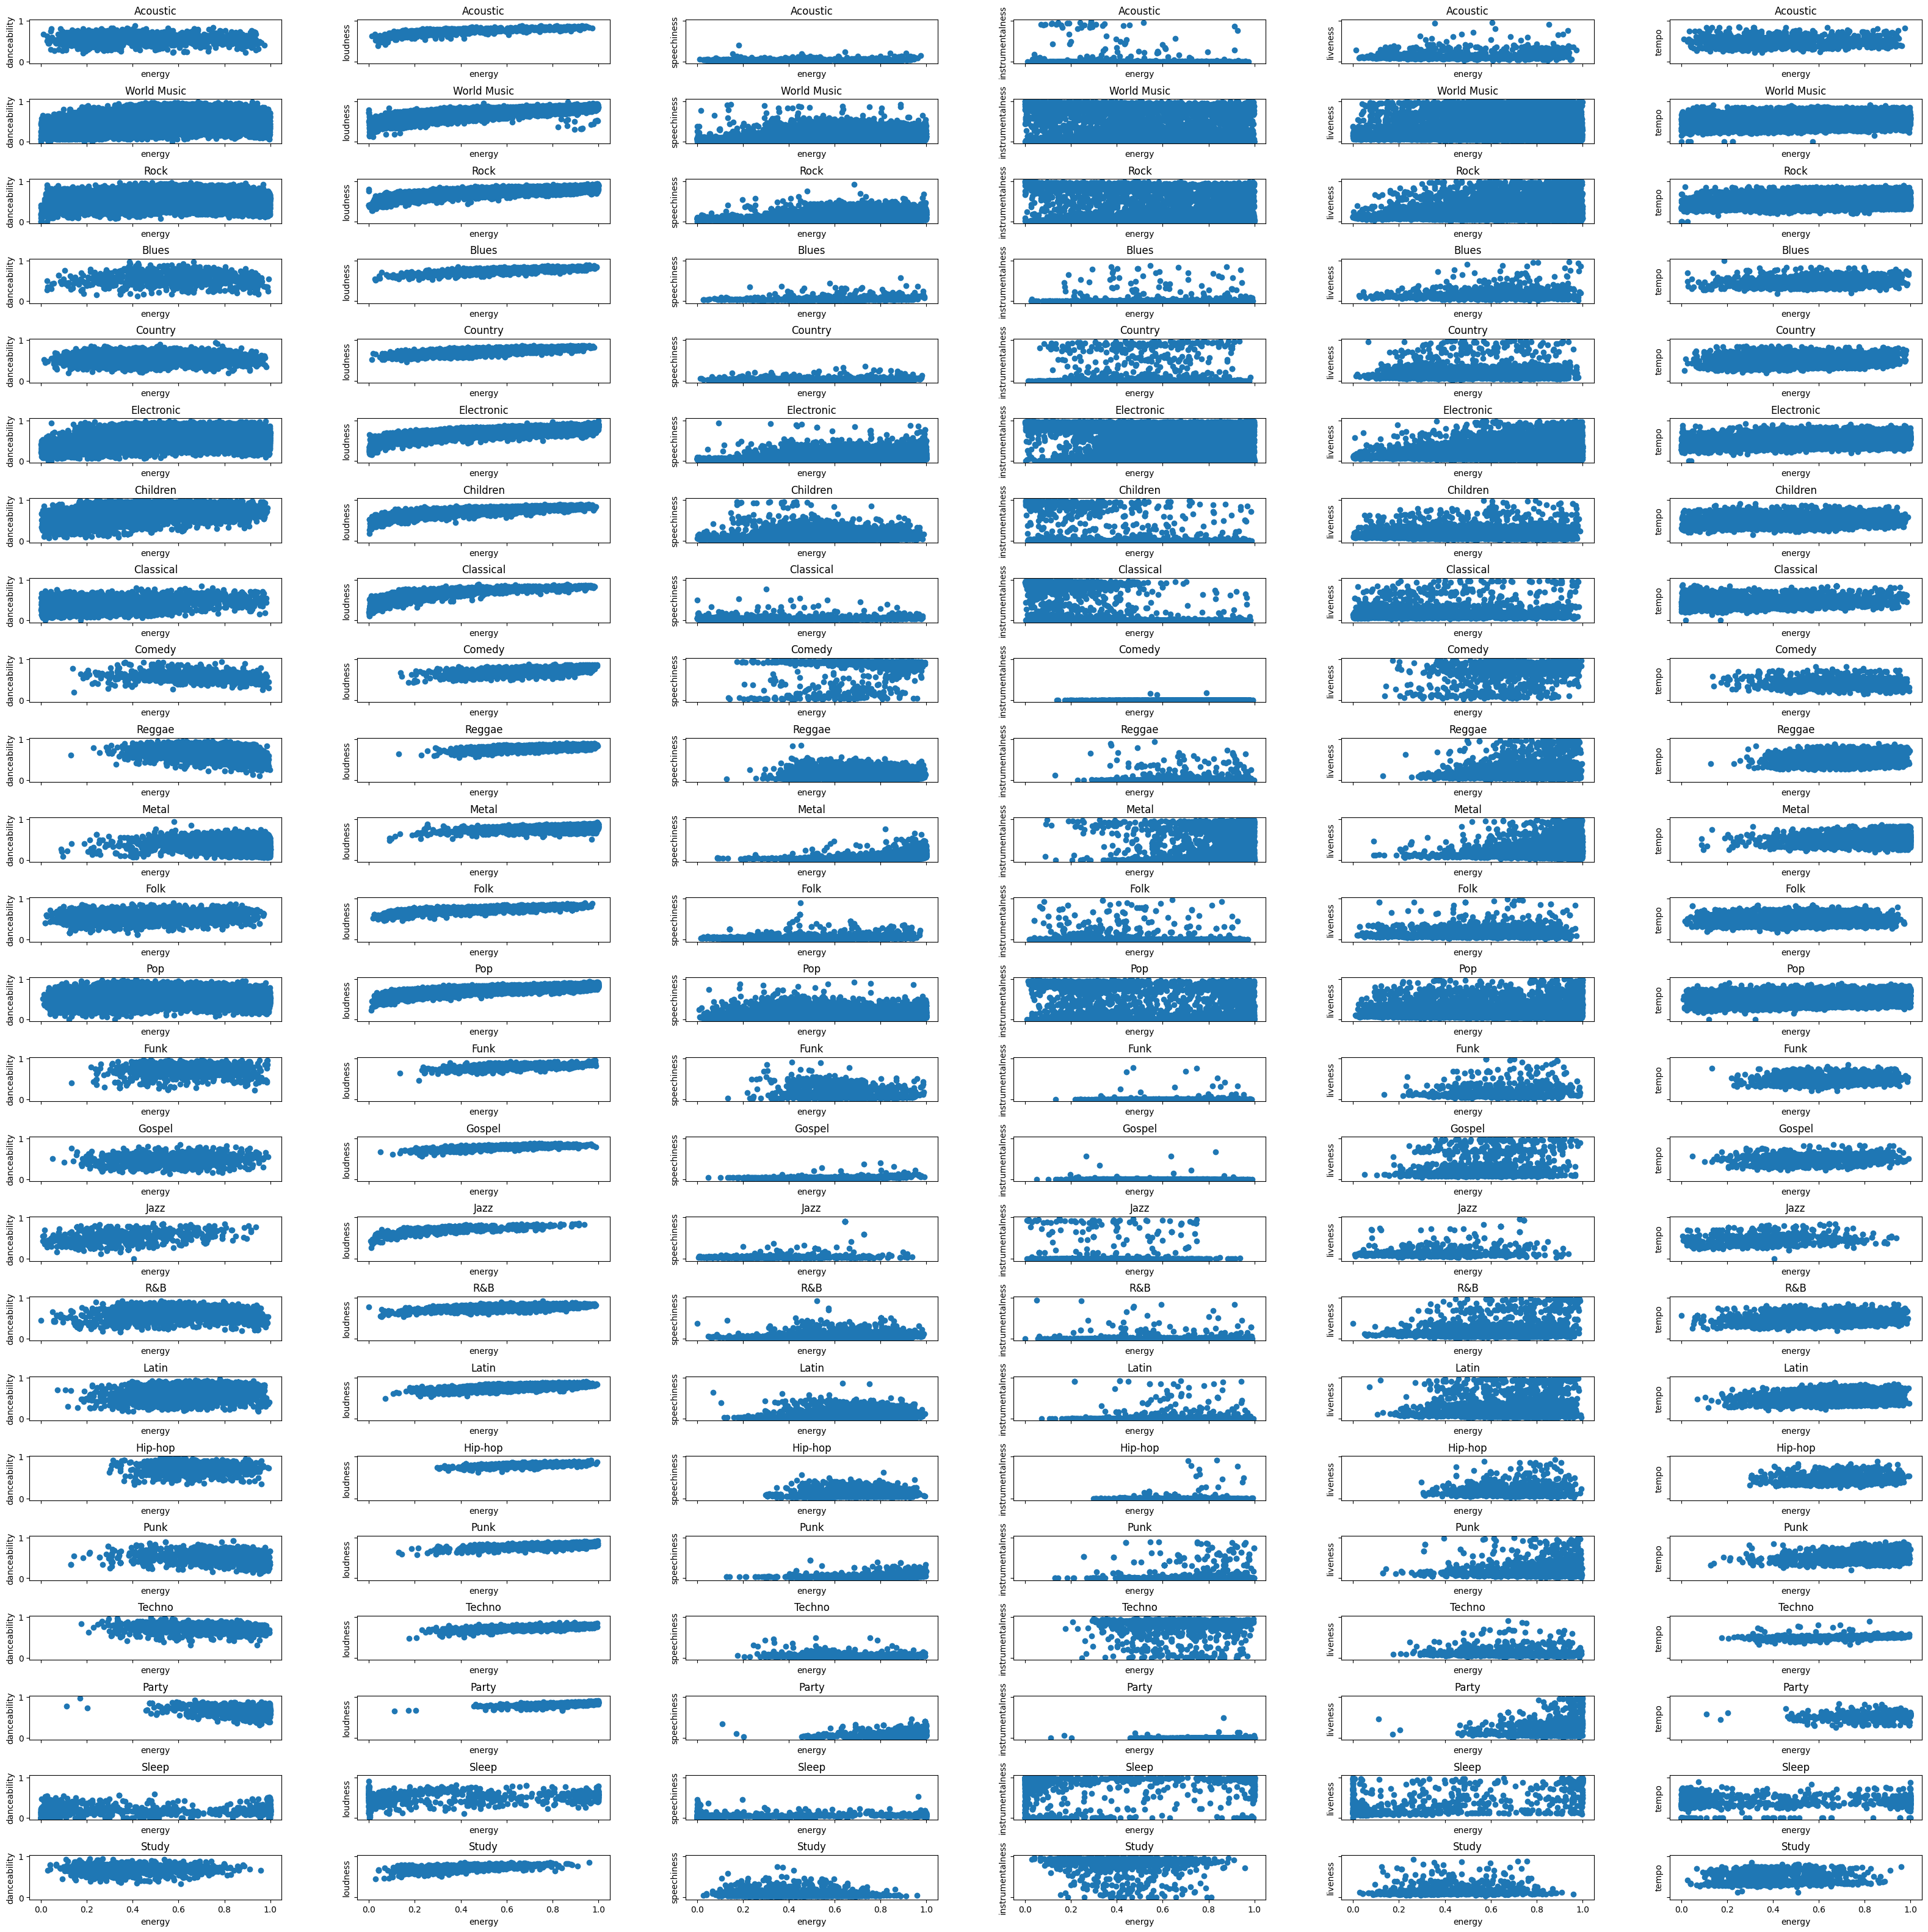

In [75]:
potential_outliers = ["danceability", "loudness", "speechiness", "instrumentalness", "liveness", "tempo"]
# Create subplots with spacing
# Define the number of rows and columns for subplots

num_cols = len(potential_outliers)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 40), sharex='col', sharey='row', 
                         gridspec_kw={'hspace': 0.8, 'wspace': 0.3})

# Iterate over each basic genre
for i, (basic_genre, subgenres) in enumerate(genre_mappings.items()):
    # Filter the DataFrame for tracks belonging to the current basic genre
    filtered_df = track_df[track_df['track_genre'].isin(subgenres)]
    
    # Iterate over each potential outlier column
    for j, col in enumerate(potential_outliers):
        # Scatter plot
        axes[i, j].scatter(x=filtered_df['energy'], y=filtered_df[col])
        axes[i, j].set_title(f"{basic_genre}")
        axes[i, j].set_xlabel("energy", fontsize=10)
        axes[i, j].set_ylabel(col, fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

Correlation Matrices

/var/folders/d8/r30nz4q57b17kphtz7nm89b40000gn/T/ipykernel_73335/3961445268.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop('track_id', axis=1, inplace=True)
/var/folders/d8/r30nz4q57b17kphtz7nm89b40000gn/T/ipykernel_73335/3961445268.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop('track_genre', axis=1, inplace=True)
/var/folders/d8/r30nz4q57b17kphtz7nm89b40000gn/T/ipykernel_73335/3961445268.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

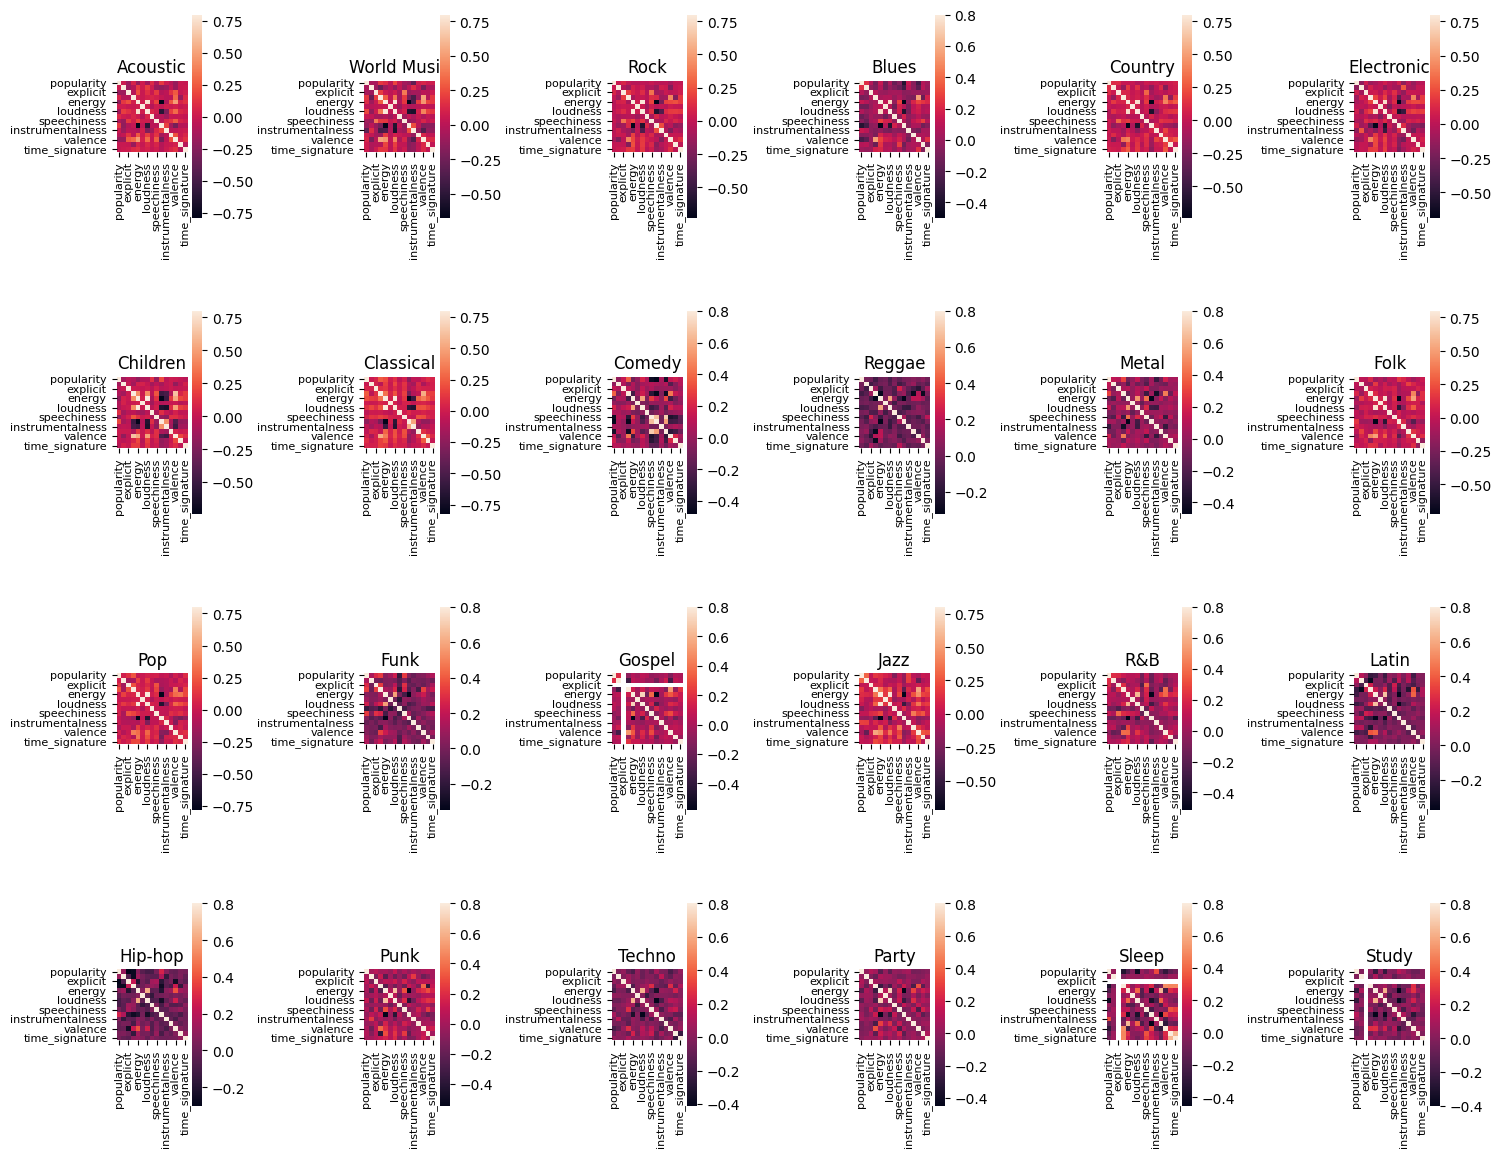

In [76]:
#get lengths of genres and rows and columns for plots

num_genres = len(genre_mappings)
rows = int(num_genres ** 0.5)
cols = (num_genres + rows - 1) // rows
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()

#create heatmap for each genre
for i, (basic_genre, subgenres) in enumerate(genre_mappings.items()):
    # Filter the DataFrame for tracks belonging to the current basic genre
    filtered_df = track_df[track_df['track_genre'].isin(subgenres)]
    
    #drop non-numerical cols
    filtered_df.drop('track_id', axis=1, inplace=True)
    filtered_df.drop('track_genre', axis=1, inplace=True)

    #create heatmap
    corrmat = filtered_df.corr()
    sns.heatmap(corrmat, ax=axes[i], vmax=0.8, square=True)
    axes[i].set_title(basic_genre)
    axes[i].tick_params(axis='both', which='major', labelsize=8)

#remove subplot axes
for j in range(i + 1, rows * cols):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

Normalizing Skewed Values

In [77]:
#look at numeric columns only
numeric_cols = track_df.dtypes[
    (track_df.dtypes != "object")
].index

#create value to represent skewness
skewed_values = (track_df[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({"Skew": skewed_values})
skewness.head(20)


Skew in numerical features: 



Skew
duration_ms       11.195034
speechiness        4.647455
explicit           2.964692
liveness           2.105710
instrumentalness   1.734383
acousticness       0.727285
tempo              0.232292
valence            0.115077
popularity         0.046402
key               -0.008500
danceability      -0.399491
mode              -0.572293
energy            -0.596994
loudness          -2.006516
time_signature    -4.098263

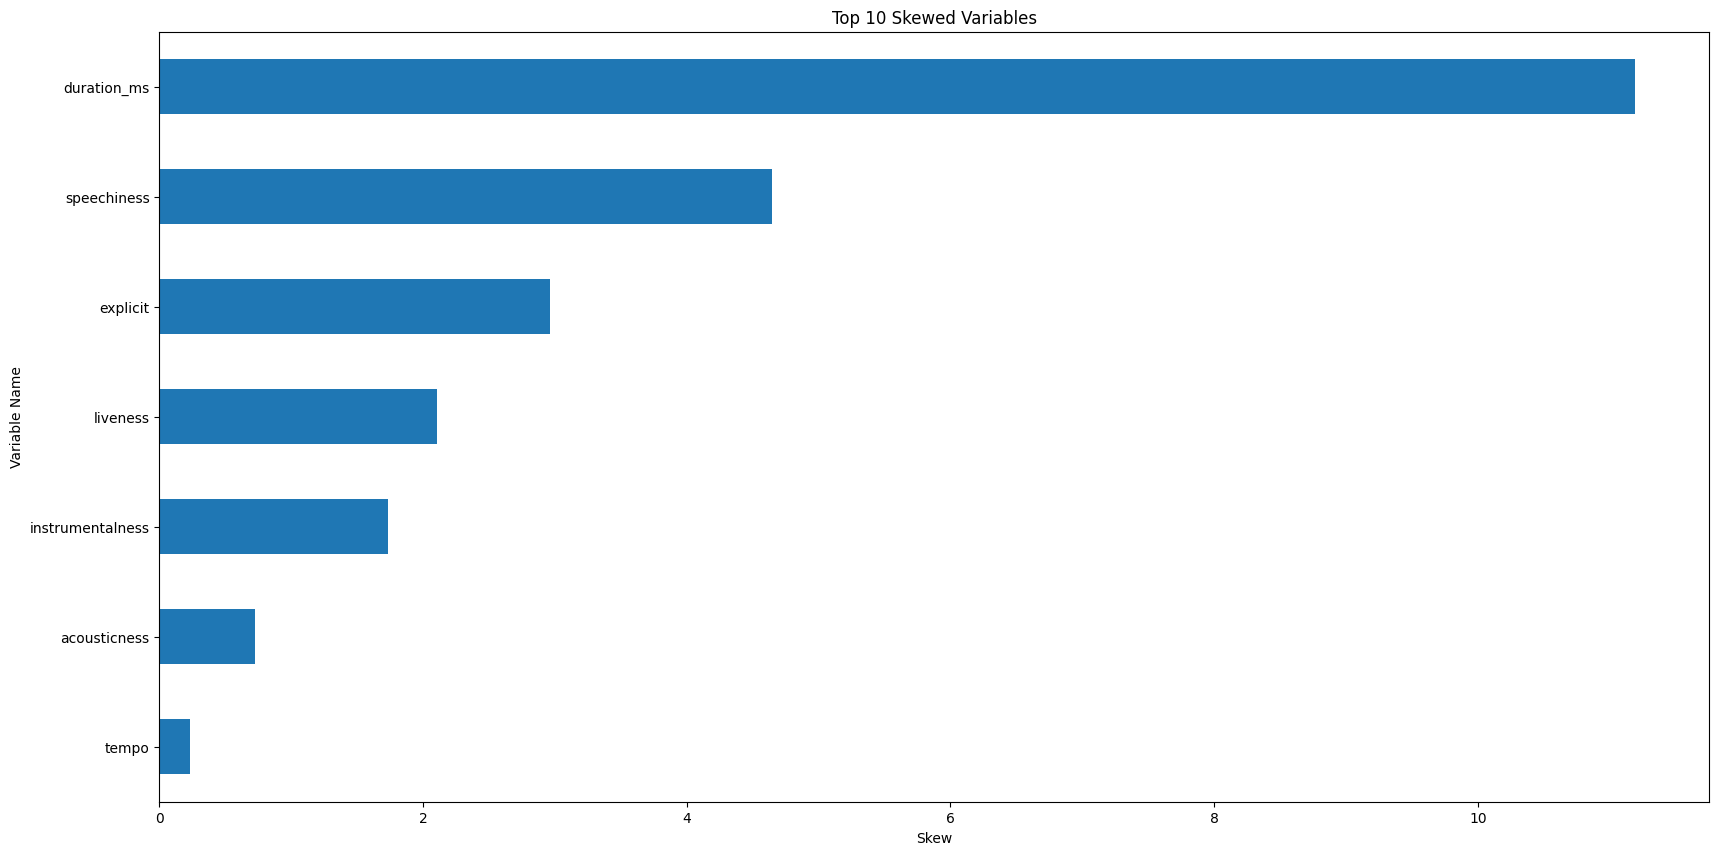

In [78]:
#take top 7 most skewed values and plot them (the rest are insignificant)
skewness["Skew"].head(7).plot(kind="barh", figsize=(20, 10)).invert_yaxis()

#plotting
plt.xlabel("Skew")
plt.ylabel("Variable Name")
plt.title("Top 10 Skewed Variables")
plt.show()

In [79]:
skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #normalize features as long as they are changeable metrically
    if feat not in [
        "key",
        "time_signature",
        "explicit",
        "duration_ms",
    ]:
        track_df[feat] = boxcox1p(track_df[feat], lam)

In [80]:
#check for any null values after normalization
null_columns = track_df.columns[track_df.isnull().any()]
null_count = track_df[null_columns].isnull().sum()

print("Column Name: NULL Count")
for i in range(0, len(null_columns)):
    print(f"{null_columns[i]}: {null_count[i]}")

Column Name: NULL Count


# Data Analytics

In [81]:
!pip3 install xgboost

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [83]:
#separate features and labels
bad_cols = ['track_genre', 'track_id', 'time_signature', 'key']
X = track_df.drop(bad_cols, axis = 1)
y = track_df['track_genre']

#create training and testing data using X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Random Forest Classifier

In [84]:
#fit data into RandomForestRegressor for prediction specific genres
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}") 

# Accuracy scores for each class
class_report = classification_report(y_test, y_pred)
print("Accuracy Scores for Each Class:")
print(class_report)

#5-fold cross validation
#k = 5
#cv_scores = cross_val_score(model, X, y, cv=k, scoring='accuracy')
#print(f"Mean accuracy: {cv_scores.mean():.2f}")
#print(f"Standard deviation of accuracy: {cv_scores.std():.2f}")
#model is not extremely precise likely because of the number of genres

Accuracy: 0.33
Accuracy Scores for Each Class:
                   precision    recall  f1-score   support

         acoustic       0.30      0.25      0.27       208
         afrobeat       0.39      0.41      0.40       204
         alt-rock       0.03      0.04      0.03       193
      alternative       0.13      0.13      0.13       190
          ambient       0.28      0.33      0.30       202
            anime       0.18      0.15      0.16       195
      black-metal       0.52      0.54      0.53       180
        bluegrass       0.44      0.58      0.50       204
            blues       0.14      0.09      0.11       207
           brazil       0.09      0.08      0.08       212
        breakbeat       0.54      0.44      0.48       206
          british       0.16      0.08      0.11       216
         cantopop       0.26      0.30      0.28       194
    chicago-house       0.59      0.54      0.56       202
         children       0.47      0.51      0.49       186
        

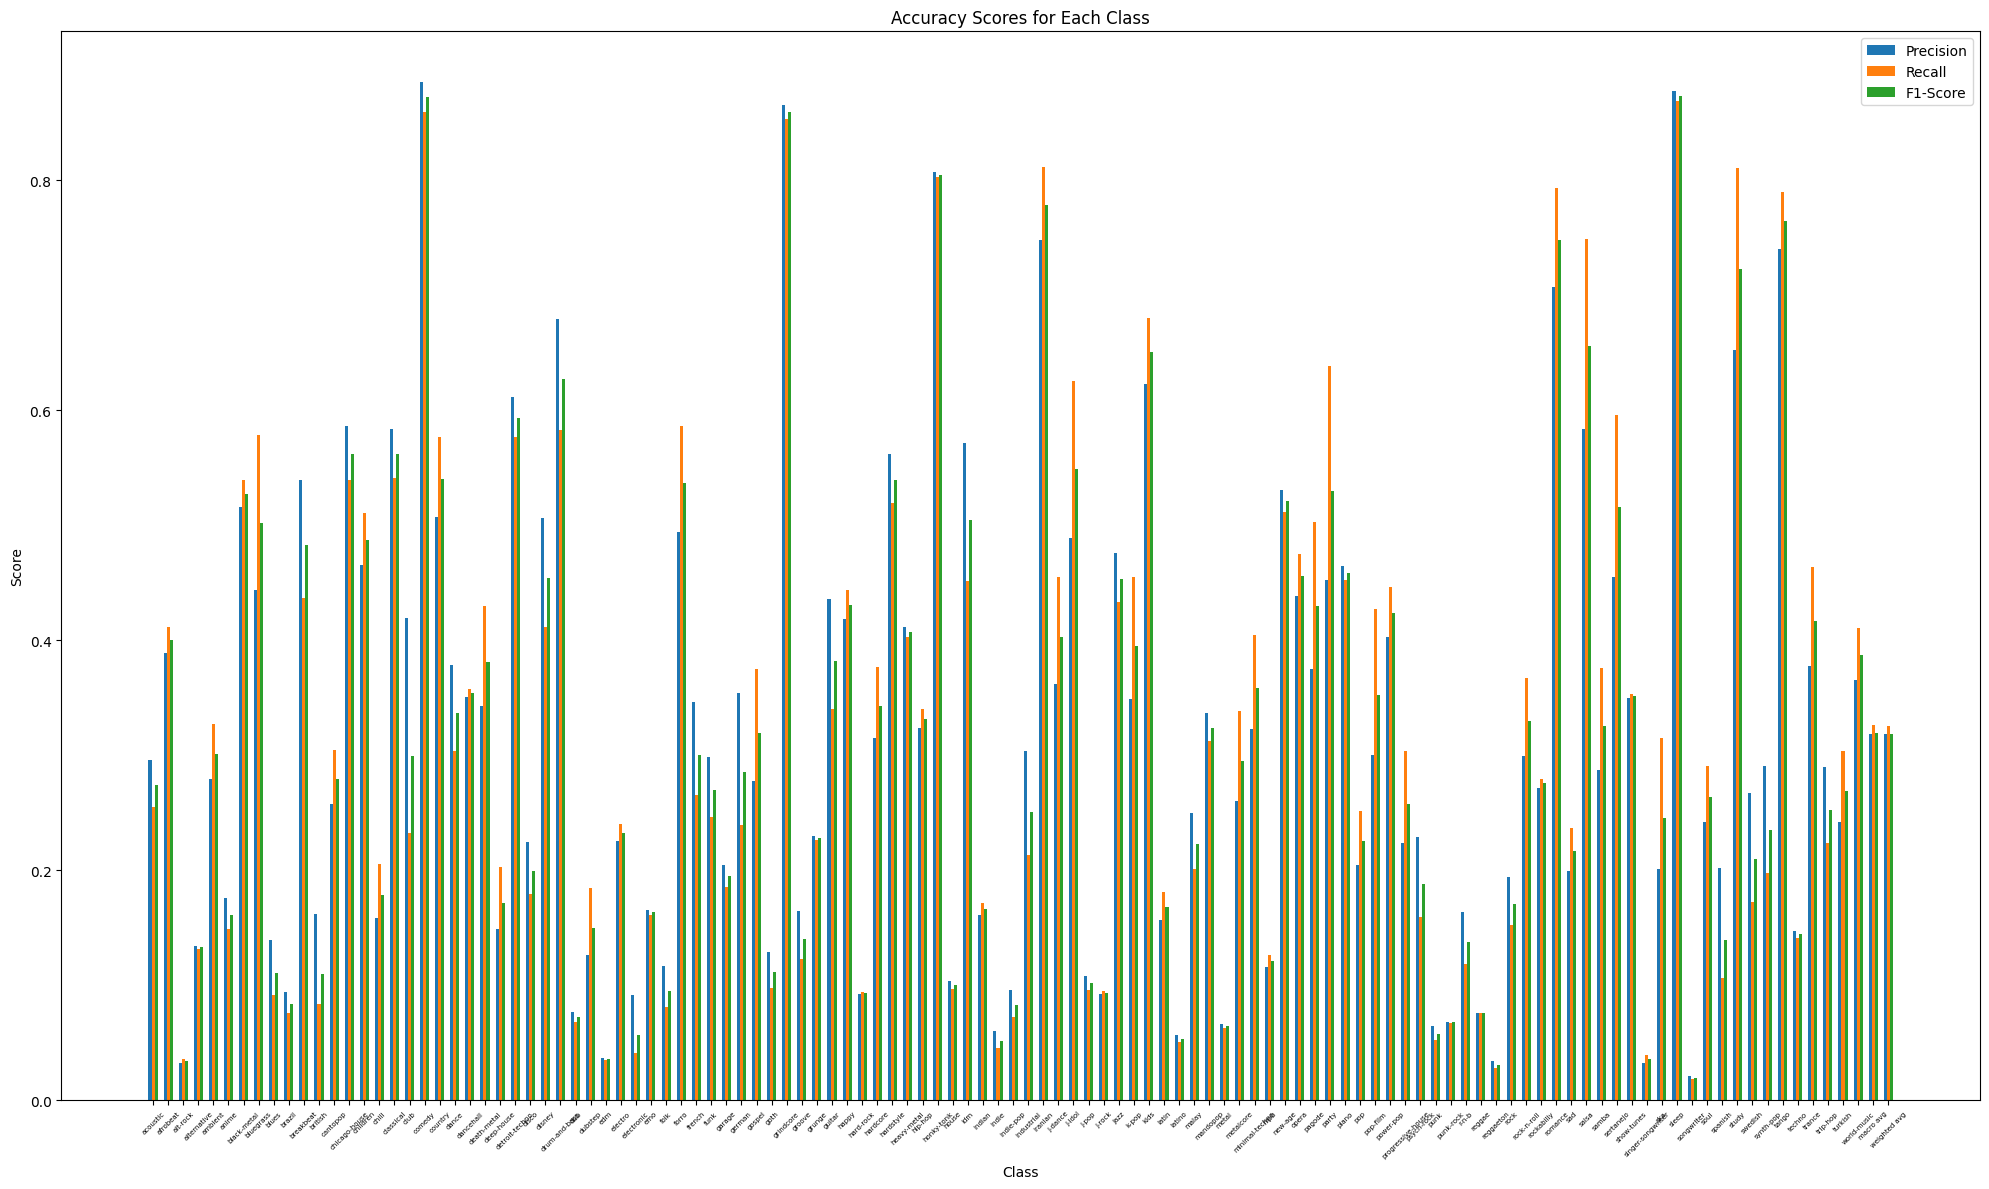

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have already calculated class_report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Exclude 'accuracy' from keys
class_report.pop('accuracy', None)

# Extract precision, recall, and F1-score for each class
classes = list(class_report.keys())
precision = [class_report[label]['precision'] for label in classes]
recall = [class_report[label]['recall'] for label in classes]
f1_score = [class_report[label]['f1-score'] for label in classes]

# Plotting
fig, ax = plt.subplots(figsize=(20, 12))  # Enlarged the figure size

# Set positions for the bars
bar_width = 0.2
index = np.arange(len(classes))

# Plot bars for precision, recall, and F1-score
plt.bar(index, precision, bar_width, label='Precision')
plt.bar(index + bar_width, recall, bar_width, label='Recall')
plt.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score')

# Add labels, title, and legend
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Accuracy Scores for Each Class')
plt.xticks(index + bar_width, classes, rotation=45, fontsize=5)  # Rotated labels and reduced font size
plt.legend()

plt.tight_layout()
plt.show()


In [86]:
#Lets try the same method with more general genres

#this function allows us to use our genre_mappings dictionary and map to our dataframe easily
def map_to_general_genre(subgenre):
    for general_genre, subgenres in genre_mappings.items():
        if subgenre in subgenres:
            return general_genre
    return 'World-Music'  # Return most general genre if no general genre matches (Null imputation)

#use this function to map general genres to df
track_df['general_genre'] = track_df['track_genre'].apply(map_to_general_genre)
y = track_df['general_genre']

In [87]:
#create training and testing data with the new values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
#reuse RandomForestClassifier
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}") 
#5-fold cross validation
k = 5
cv_scores = cross_val_score(model, X, y, cv=k, scoring='accuracy')
print(f"Mean accuracy: {cv_scores.mean():.2f}")
print(f"Standard deviation of accuracy: {cv_scores.std():.2f}")
#using the same model and state, we can see that the more general genres are easier to predict


Accuracy: 0.54
Mean accuracy: 0.39
Standard deviation of accuracy: 0.03


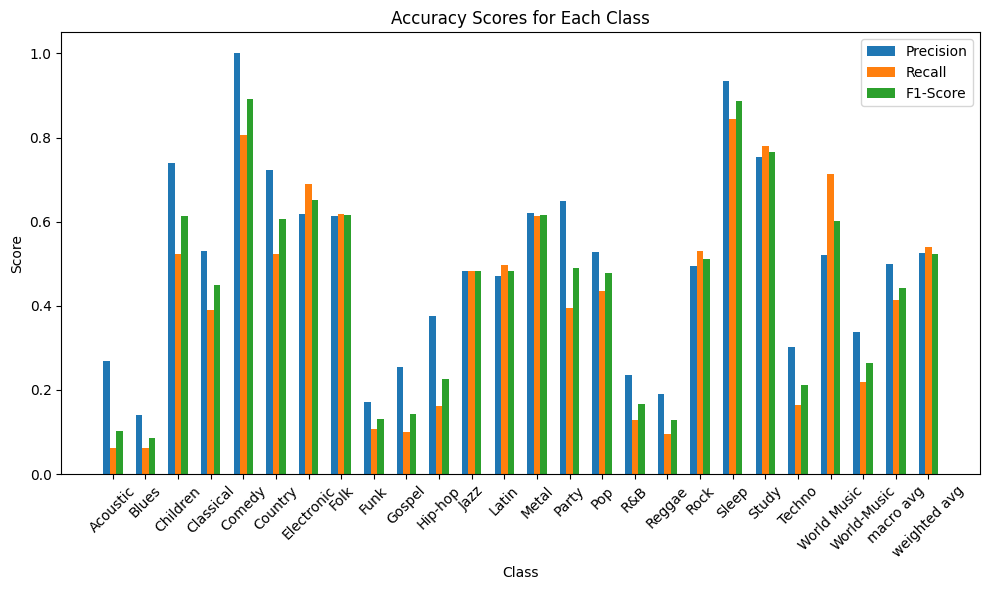

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have already calculated class_report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Exclude 'accuracy' from keys
class_report.pop('accuracy', None)

# Extract precision, recall, and F1-score for each class
classes = list(class_report.keys())
precision = [class_report[label]['precision'] for label in classes]
recall = [class_report[label]['recall'] for label in classes]
f1_score = [class_report[label]['f1-score'] for label in classes]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Set positions for the bars
bar_width = 0.2
index = np.arange(len(classes))

# Plot bars for precision, recall, and F1-score
plt.bar(index, precision, bar_width, label='Precision')
plt.bar(index + bar_width, recall, bar_width, label='Recall')
plt.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score')

# Add labels, title, and legend
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Accuracy Scores for Each Class')
plt.xticks(index + bar_width, classes, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


K Nearest Neighbors Classifier

In [89]:
#test specific genres with KNN Classifier
bad_cols = ['track_genre', 'track_id', 'time_signature', 'key', 'general_genre']
X = track_df.drop(bad_cols, axis = 1)
y = track_df['track_genre']
#create training and testing data using X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#fit data into RandomForestRegressor for prediction specific genres
model = KNeighborsClassifier(n_neighbors=5, weights='distance')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}") 

Accuracy: 0.09


In [90]:
track_df['general_genre'] = track_df['track_genre'].apply(map_to_general_genre)
y = track_df['general_genre']
#create training and testing data with the new values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#reuse RandomForestClassifier
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}") 
#much worse of an approach possibly due to complexity and dimensionality of features

Accuracy: 0.30
